In [1]:
%cd ../..

C:\Users\zain.hanif\Desktop\HIS Project\Modern-Time-Series-Forecasting-with-Python


In [4]:
import math
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
from src.utils.general import LogTime
from tqdm.autonotebook import tqdm
from IPython.display import display, HTML

# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

In [6]:
os.makedirs("imgs/chapter_6", exist_ok=True)
preprocessed = Path("C:/Users/zain.hanif/Desktop/HIS Project/Modern-Time-Series-Forecasting-with-Python/data/london_smart_meters/preprocessed")

# Reading the preprocessed files

In [8]:
#Readin the missing value imputed and train test split data
try:
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed.parquet")
    val_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed.parquet")
    test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Setting up Experiment Harness.ipynb in Chapter04
    </div>
    """))

## Combining the train, validation and test datasets for Feature Engineering

Some of the features that we are creating needs the train and test dataset to be combined into a single dataset with continuous time. In case of real-life operations, where we will not have the test set, it is recommended to create the test period dataset with zero or nulled out actual observations and continue.

In [10]:
train_df["type"] = "train"
val_df["type"] = "val"
test_df["type"] = "test"
#Concatinating all the data
full_df = pd.concat([train_df, val_df, test_df]).sort_values(["LCLid", "timestamp"])
del train_df, test_df, val_df

## Lag Features

In [65]:
from src.feature_engineering.autoregressive_features import add_lags

In [67]:
#creatign first 5 lags, then creating same lags but from previous day then creating lags from previous week
lags = (
    (np.arange(5) + 1).tolist()
    + (np.arange(5) + 46).tolist()
    + (np.arange(5) + (48 * 7) - 2).tolist()
)
lags

[1, 2, 3, 4, 5, 46, 47, 48, 49, 50, 334, 335, 336, 337, 338]

In [90]:
import warnings
#Adding this to ignore warning
warnings.filterwarnings("ignore")

with LogTime():
    full_df, added_features = add_lags(
        #Adding Lags here in Energy Cinsuption Column based LCLid 
        full_df, lags=lags, column="energy_consumption", ts_id="LCLid", use_32_bit=True
    )
print(f"Features Created: {', '.join(added_features)}")

Time Elapsed: 2 seconds
Features Created: energy_consumption_lag_1, energy_consumption_lag_2, energy_consumption_lag_3, energy_consumption_lag_4, energy_consumption_lag_5, energy_consumption_lag_46, energy_consumption_lag_47, energy_consumption_lag_48, energy_consumption_lag_49, energy_consumption_lag_50, energy_consumption_lag_334, energy_consumption_lag_335, energy_consumption_lag_336, energy_consumption_lag_337, energy_consumption_lag_338


## Rolling

In [81]:
from src.feature_engineering.autoregressive_features import add_rolling_features

In [96]:
with LogTime():
    full_df, added_features = add_rolling_features(
        full_df,
        #Adding window rolling values
        rolls=[3, 6, 12, 48],
        column="energy_consumption",
        #Adding function
        agg_funcs=["mean", "std"],
        ts_id="LCLid",
        use_32_bit=True,
    )
print(f"Features Created: {', '.join(added_features)}")

Time Elapsed: 12 seconds
Features Created: energy_consumption_rolling_3_mean, energy_consumption_rolling_3_std, energy_consumption_rolling_6_mean, energy_consumption_rolling_6_std, energy_consumption_rolling_12_mean, energy_consumption_rolling_12_std, energy_consumption_rolling_48_mean, energy_consumption_rolling_48_std


## Seasonal Rolling

In [84]:
from src.feature_engineering.autoregressive_features import (
    add_seasonal_rolling_features,
)

In [86]:
#pip install window_ops
with LogTime():
    full_df, added_features = add_seasonal_rolling_features(
        full_df,
        #Adding window rolling values
        rolls=[3],
        #Adding seasonal rolling values
        seasonal_periods=[48, 48 * 7],
        column="energy_consumption",
        agg_funcs=["mean", "std"],
        ts_id="LCLid",
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 16 seconds
Features Created: energy_consumption_48_seasonal_rolling_3_mean,energy_consumption_48_seasonal_rolling_3_std,energy_consumption_336_seasonal_rolling_3_mean,energy_consumption_336_seasonal_rolling_3_std


## EWMA

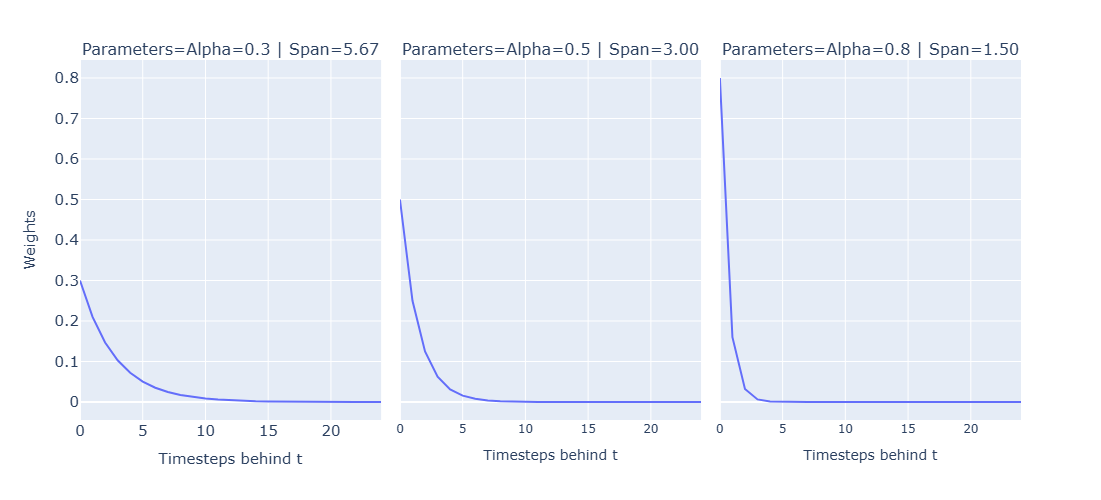

In [98]:
t = np.arange(25).tolist()
plot_df = pd.DataFrame({"Timesteps behind t": t})
for alpha in [0.3, 0.5, 0.8]:
    weights = [alpha * math.pow((1 - alpha), i) for i in t]
    span = (2 - alpha) / alpha
    halflife = math.log(1 - alpha) / math.log(0.5)
    plot_df[f"Alpha={alpha} | Span={span:.2f}"] = weights

fig = px.line(
    pd.melt(plot_df, id_vars="Timesteps behind t", var_name="Parameters"),
    x="Timesteps behind t",
    y="value",
    facet_col="Parameters",
)
fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
    yaxis=dict(
        title_text="Weights",
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
    xaxis=dict(
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
)
fig.update_annotations(font=dict(size=16))
fig.write_image(f"imgs/chapter_6/ewma_weights.png")
fig.show()

In [100]:
from src.feature_engineering.autoregressive_features import add_ewma

In [102]:
with LogTime():
    # full_df, added_features = add_ewma(full_df, alphas=[0.2, 0.5, 0.9], column="energy_consumption", ts_id="LCLid", use_32_bit=True)
    full_df, added_features = add_ewma(
        full_df,
        spans=[48 * 60, 48 * 7, 48],
        column="energy_consumption",
        ts_id="LCLid",
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 7 seconds
Features Created: energy_consumption_ewma_span_2880,energy_consumption_ewma_span_336,energy_consumption_ewma_span_48


## Temporal Features

In [33]:
from src.feature_engineering.temporal_features import add_temporal_features

In [104]:
with LogTime():
    full_df, added_features = add_temporal_features(
        full_df,
        field_name="timestamp",
        frequency="30min",
        add_elapsed=True,
        drop=False,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 2 seconds
Features Created: timestamp_Month,timestamp_Quarter,timestamp_Is_quarter_end,timestamp_Is_quarter_start,timestamp_Is_year_end,timestamp_Is_year_start,timestamp_Is_month_start,timestamp_WeekDay,timestamp_Dayofweek,timestamp_Dayofyear,timestamp_Hour,timestamp_Minute,timestamp_Elapsed


## Fourier Terms

In [36]:
from src.feature_engineering.temporal_features import (
    add_fourier_features,
    bulk_add_fourier_features,
)

In [37]:
# train_df, added_features = add_fourier_features(train_df, "timestamp_Month", max_value=12, n_fourier_terms=1)

In [38]:
with LogTime():
    full_df, added_features = bulk_add_fourier_features(
        full_df,
        ["timestamp_Month", "timestamp_Hour", "timestamp_Minute"],
        max_values=[12, 24, 60],
        n_fourier_terms=5,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 4 seconds
Features Created: timestamp_Month_sin_1,timestamp_Month_sin_2,timestamp_Month_sin_3,timestamp_Month_sin_4,timestamp_Month_sin_5,timestamp_Month_cos_1,timestamp_Month_cos_2,timestamp_Month_cos_3,timestamp_Month_cos_4,timestamp_Month_cos_5,timestamp_Hour_sin_1,timestamp_Hour_sin_2,timestamp_Hour_sin_3,timestamp_Hour_sin_4,timestamp_Hour_sin_5,timestamp_Hour_cos_1,timestamp_Hour_cos_2,timestamp_Hour_cos_3,timestamp_Hour_cos_4,timestamp_Hour_cos_5,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5


In [39]:
full_df.columns

Index(['timestamp', 'LCLid', 'energy_consumption', 'frequency',
       'series_length', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file',
       'holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary', 'type', 'energy_consumption_lag_1',
       'energy_consumption_lag_2', 'energy_consumption_lag_3',
       'energy_consumption_lag_4', 'energy_consumption_lag_5',
       'energy_consumption_lag_46', 'energy_consumption_lag_47',
       'energy_consumption_lag_48', 'energy_consumption_lag_49',
       'energy_consumption_lag_50', 'energy_consumption_lag_334',
       'energy_consumption_lag_335', 'energy_consumption_lag_336',
       'energy_consumption_lag_337', 'energy_consumption_lag_338',
       'energy_consumption_rolling_3_mean', 'energy_consumption_rolling_3_std',
       'energy_consumption_rolling_6_mean', 'energy_consumption_rolling_6_std',
       'energy_consumption_rolli

### Plotting Fourier Terms

In [106]:
plot_df = (
    full_df[["timestamp_Month", "timestamp_Month_sin_1"]]
    .drop_duplicates()
    .sort_values("timestamp_Month")
)

plot_df.columns = ["calendar", "fourier"]

plot_df = pd.concat([plot_df, plot_df, plot_df]).reset_index(drop=True)
# plot_df.reset_index(drop=True, inplace=True)

plot_df.reset_index(inplace=True)
plot_df["index"] += 1
plot_df = pd.melt(
    plot_df, id_vars="index", var_name="month", value_name="Representation"
)

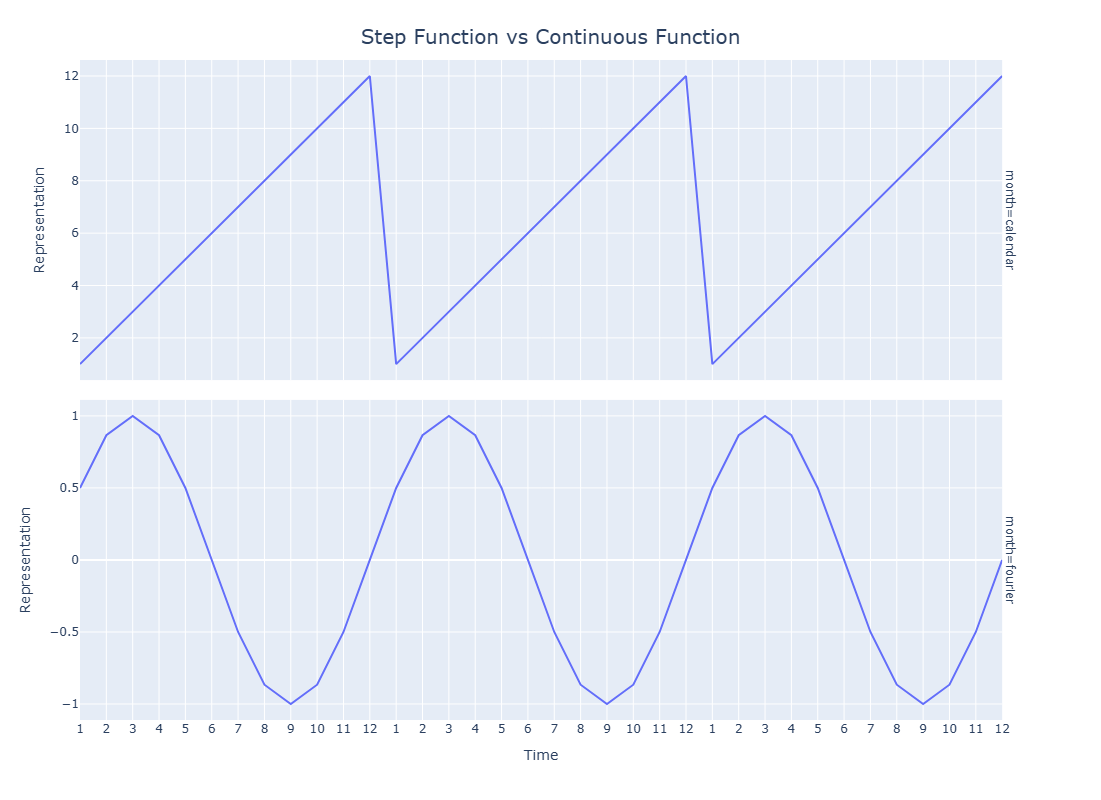

In [108]:
fig = px.line(plot_df, x="index", y="Representation", facet_row="month")
fig.update_layout(
    autosize=False,
    width=900,
    height=800,
    title_text="Step Function vs Continuous Function",
    title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
    titlefont={"size": 20},
    legend_title=None,
    # yaxis=dict(
    #     # title_text=ylabel,
    #     # titlefont=dict(size=12),
    # ),
    xaxis=dict(
        title_text="Time",
        # titlefont=dict(size=12),
    ),
)
fig.update_yaxes(matches=None)
fig.update_xaxes(
    ticktext=np.arange(1, 13).tolist() * 3,
    tickvals=np.arange(len(plot_df)) + 1,
)
fig.write_image(f"imgs/chapter_6/fourier.png")
fig.show()

# Saving the feature engineered file

In [44]:
full_df.info(memory_usage="deep", verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 4711440 entries, 0 to 32687
Columns: 95 entries, timestamp to timestamp_Minute_cos_5
dtypes: category(10), datetime64[ns](1), float32(68), int32(15), object(1)
memory usage: 1.8 GB


In [45]:
full_df[full_df["type"] == "train"].drop(columns="type").to_parquet(
    preprocessed / "selected_blocks_train_missing_imputed_feature_engg.parquet"
)
full_df[full_df["type"] == "val"].drop(columns="type").to_parquet(
    preprocessed / "selected_blocks_val_missing_imputed_feature_engg.parquet"
)
full_df[full_df["type"] == "test"].drop(columns="type").to_parquet(
    preprocessed / "selected_blocks_test_missing_imputed_feature_engg.parquet"
)